In [3]:
from FIG import FIG
import numpy as np
# Temporary PHATE / graphtools
if not hasattr(np, "float"):
    np.float = float
from PHATET import PHATET

In [4]:
from scipy import io
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load EEG data
data = io.loadmat(r'n10_8-12hz.mat')
eeg = np.transpose(data['data'])

# select all channels
Data_eeg = eeg[:,:]

# load the labels
labels_d = pd.read_excel('labelsn10.xlsx')
labels = np.array(labels_d['Unnamed: 7'])
labels  = np.reshape(labels[:860], 860)

# check the dim of the data
print(Data_eeg.shape)

time_lab = np.arange(860)

(3302400, 18)


In [5]:
import os
import time

In [ ]:
GLOBAL_SEED = 172119
np.random.seed(GLOBAL_SEED)

# --------------------------------------------------
# Output directories
# --------------------------------------------------
md_dir = "/Users/chenhaozhe/Desktop/FIG/basis_fourier_MD"
time_dir = "/Users/chenhaozhe/Desktop/FIG/computation_time"

os.makedirs(md_dir, exist_ok=True)
os.makedirs(time_dir, exist_ok=True)

# --------------------------------------------------
# Data & FIG parameters
# --------------------------------------------------
X = Data_eeg
L1 = 3840
L3 = 3840
L2 = 50

# --------------------------------------------------
# 4 x 5 Fourier hyperparameter grid
# --------------------------------------------------
num_basis_list = [5, 7, 9, 11]      # 4
period_list = [5, 10, 20, 40, 80]       # 5

# storage: rows = num_basis, cols = period
times = np.zeros((len(num_basis_list), len(period_list)))

# --------------------------------------------------
# Grid search with timing
# --------------------------------------------------
for i, num_basis in enumerate(num_basis_list):
    print(f"\n=== num_basis = {num_basis} ===")

    for j, period in enumerate(period_list):
        print(f"  period = {period}")

        fig = FIG(
            X,
            window_size=L2,
            n_components=3,
            lift_type="fourier",
            normalization="sqrt",
            num_basis=num_basis,
            period=period,
            center_window=L1,
            center_stride=L3,
        )

        start_time = time.perf_counter()
        MD = fig.fit()
        elapsed = time.perf_counter() - start_time

        times[i, j] = elapsed

        # --------------------------------------------------
        # Save MD
        # --------------------------------------------------
        md_fname = f"MD_fourier_nb{num_basis}_p{period}.npy"
        np.save(os.path.join(md_dir, md_fname), MD)

        print(f"    saved MD, time = {elapsed:.3f}s")

# --------------------------------------------------
# Save timing results + metadata
# --------------------------------------------------
np.save(os.path.join(time_dir, "fourier_times.npy"), times)

np.save(
    os.path.join(time_dir, "fourier_grid_meta.npy"),
    {
        "num_basis": num_basis_list,
        "period": period_list,
        "window_size": L2,
        "center_window": L1,
        "center_stride": L3,
        "seed": GLOBAL_SEED,
    },
)

print("\nTiming matrix saved to:", time_dir)


In [ ]:
# -------------------------------------------------
# # Directory with Fourier MD matrices
# --------------------------------------------------
base_dir = "/Users/chenhaozhe/Desktop/FIG/basis_fourier_MD"

# --------------------------------------------------
# Collect all MD files
# --------------------------------------------------
md_files = sorted([
    f for f in os.listdir(base_dir)
    if f.startswith("MD_") and f.endswith(".npy")
])

print(f"Found {len(md_files)} MD files")

# --------------------------------------------------
# Loop over all MD matrices
# --------------------------------------------------
for fname in md_files:
    print(f"\nProcessing {fname}")

    path = os.path.join(base_dir, fname)
    MD = np.load(path)

    # --------------------------------------------------
    # PHATE → 10D (precomputed distance)
    # --------------------------------------------------
    phate_10d = PHATET(
        knn_dist="precomputed_distance",
        k=20,
        n_components=10,
        verbose=0,
    )

    Z_10d = phate_10d.fit_transform(MD)

    # --------------------------------------------------
    # PHATE → 2D
    # --------------------------------------------------
    phate_2d = PHATET(
        n_components=2,
        k=20,
        verbose=0,
    )

    fig_2d = phate_2d.fit_transform(Z_10d)

    # --------------------------------------------------
    # PHATE → 3D
    # --------------------------------------------------
    phate_3d = PHATET(
        n_components=3,
        k=20,
        verbose=0,
    )

    fig_3d = phate_3d.fit_transform(Z_10d)

    # --------------------------------------------------
    # Save embeddings
    # --------------------------------------------------
    base = fname.replace(".npy", "")

    out_2d = os.path.join(base_dir, f"fig_2d_{base}.npy")
    out_3d = os.path.join(base_dir, f"fig_3d_{base}.npy")

    np.save(out_2d, fig_2d)
    np.save(out_3d, fig_3d)

    print(f"  saved -> {out_2d}")
    print(f"  saved -> {out_3d}")


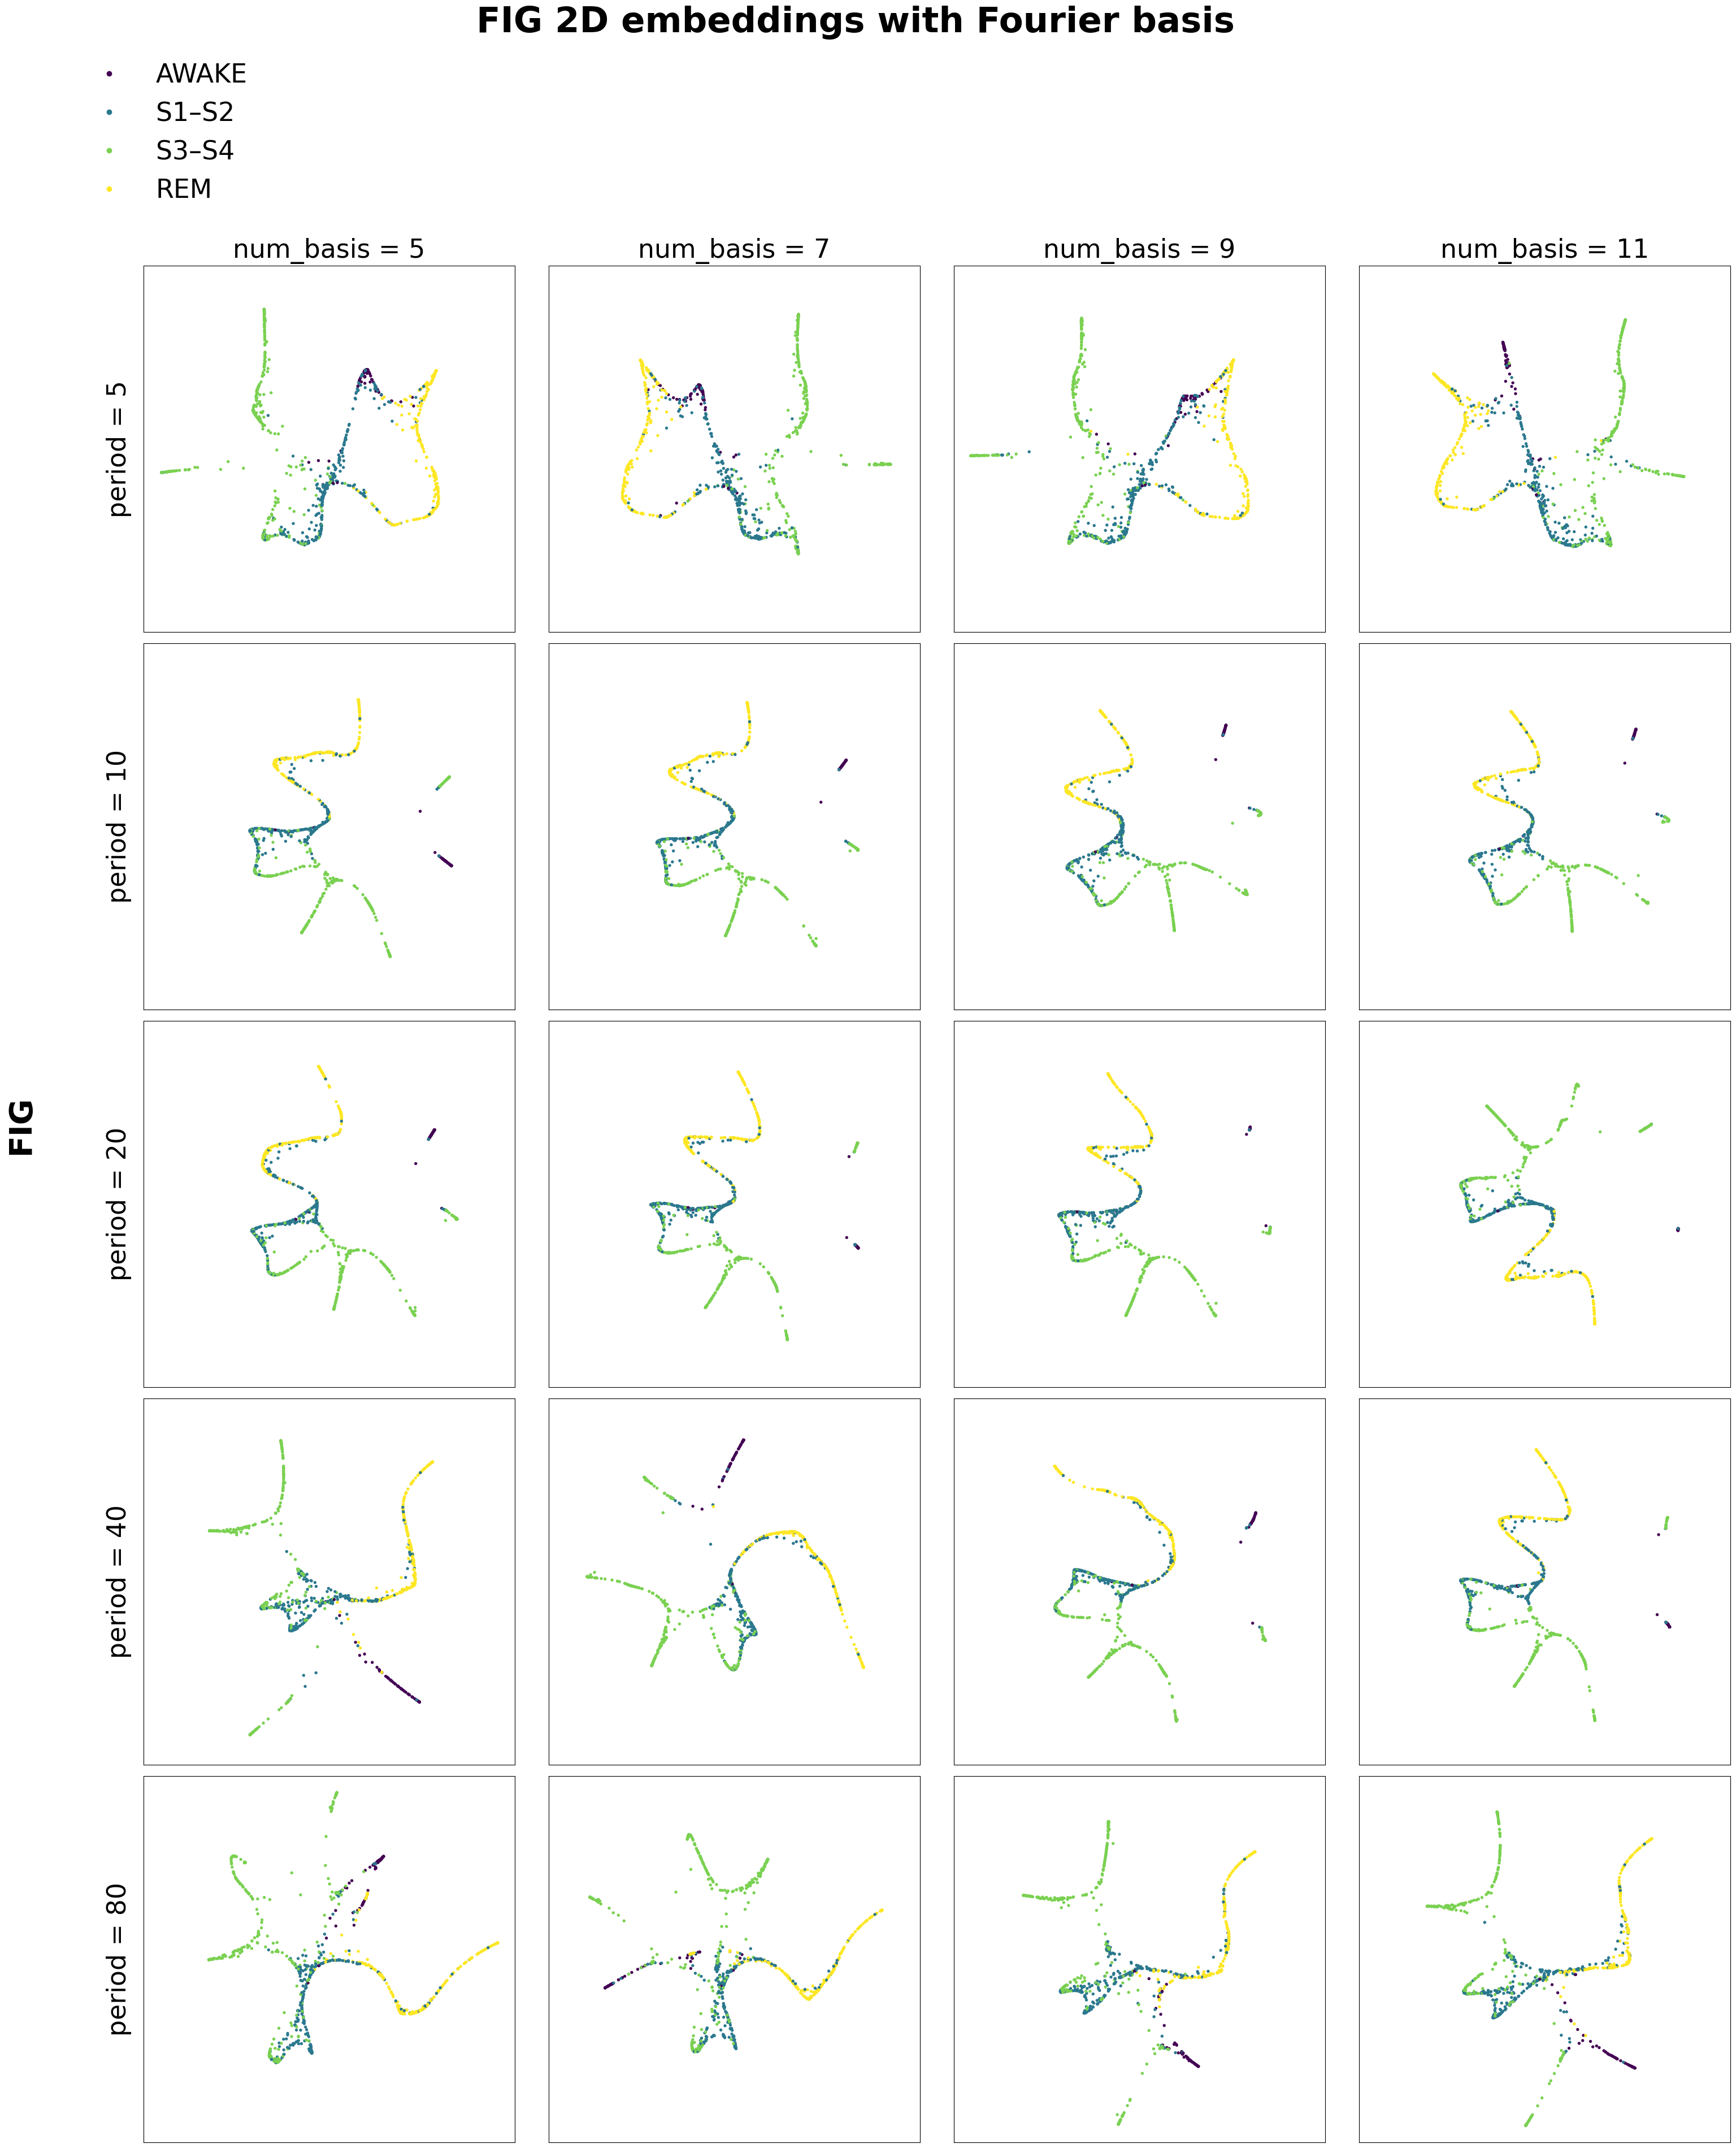

In [10]:
from matplotlib import pyplot as plt

# Make a copy so we don't destroy the original labels
labels_merged = labels.copy()

# Merge sleep stages
labels_merged[np.isin(labels_merged, [1, 2])] = 2   # S1-S2
labels_merged[np.isin(labels_merged, [3, 4])] = 4   # S3-S4


# ==================================================
# Step 0: merge labels (DO THIS FIRST)
# ==================================================
labels_merged = labels.copy()

labels_merged[np.isin(labels_merged, [1, 2])] = 2   # S1–S2
labels_merged[np.isin(labels_merged, [3, 4])] = 4   # S3–S4

# ==================================================
# Directory
# ==================================================
base_dir = "/Users/chenhaozhe/Desktop/FIG/basis_fourier_MD"

# ==================================================
# Grid definition (4 x 5)
# ==================================================
num_basis_list = [5, 7, 9, 11]          # columns
period_list = [5, 10, 20, 40, 80]       # rows

# ==================================================
# Legend dictionary (merged labels)
# ==================================================
legend_dict = {
    0: "AWAKE",
    2: "S1–S2",
    4: "S3–S4",
    5: "REM",
}

# ==================================================
# Dummy scatter (for legend handles only)
# ==================================================
dummy_path = os.path.join(
    base_dir, f"fig_2d_MD_fourier_nb{num_basis_list[0]}_p{period_list[0]}.npy"
)

dummy_fig = np.load(dummy_path)

scatterplot = plt.scatter(
    dummy_fig[:, 0],
    dummy_fig[:, 1],
    c=labels_merged,
    s=8,
)

plt.close()

# ==================================================
# Create figure
# ==================================================
fig, axes = plt.subplots(
    nrows=len(period_list),
    ncols=len(num_basis_list),
    figsize=(32, 40),
    sharex=True,
    sharey=True,
)

# ==================================================
# Plot loop
# ==================================================
for i, period in enumerate(period_list):
    for j, num_basis in enumerate(num_basis_list):
        ax = axes[i, j]

        fname = f"fig_2d_MD_fourier_nb{num_basis}_p{period}.npy"
        Z = np.load(os.path.join(base_dir, fname))

        ax.scatter(
            Z[:, 0],
            Z[:, 1],
            c=labels_merged,
            s=8,
        )

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal", adjustable="box")

        # Column titles (top row)
        if i == 0:
            ax.set_title(
                f"num_basis = {num_basis}",
                fontsize=33,
                pad=10,
            )

        # Row labels (left column)
        if j == 0:
            ax.set_ylabel(
                f"period = {period}",
                fontsize=33,
                rotation=90,
                labelpad=15,
            )

# ==================================================
# Global FIG label
# ==================================================
fig.text(
    0.03,
    0.5,
    "FIG",
    va="center",
    rotation="vertical",
    fontsize=40,
    fontweight="bold",
)

# ==================================================
# Global legend
# ==================================================
legend_labels = [legend_dict[label] for label in np.unique(labels_merged)]

fig.legend(
    handles=scatterplot.legend_elements()[0],
    labels=legend_labels,
    loc="upper left",
    bbox_to_anchor=(0.06, 0.98),
    fontsize=33,
    frameon=False,
)

# ==================================================
# Global title
# ==================================================
fig.suptitle(
    "FIG 2D embeddings with Fourier basis",
    fontsize=45,
    y=0.995,
    fontweight="bold",
)

# ==================================================
# Layout tuning (tight rows)
# ==================================================
plt.subplots_adjust(
    left=0.1,
    right=0.99,
    top=0.88,
    bottom=0.05,
    wspace=0.03,
    hspace=0.03,
)

plt.show()


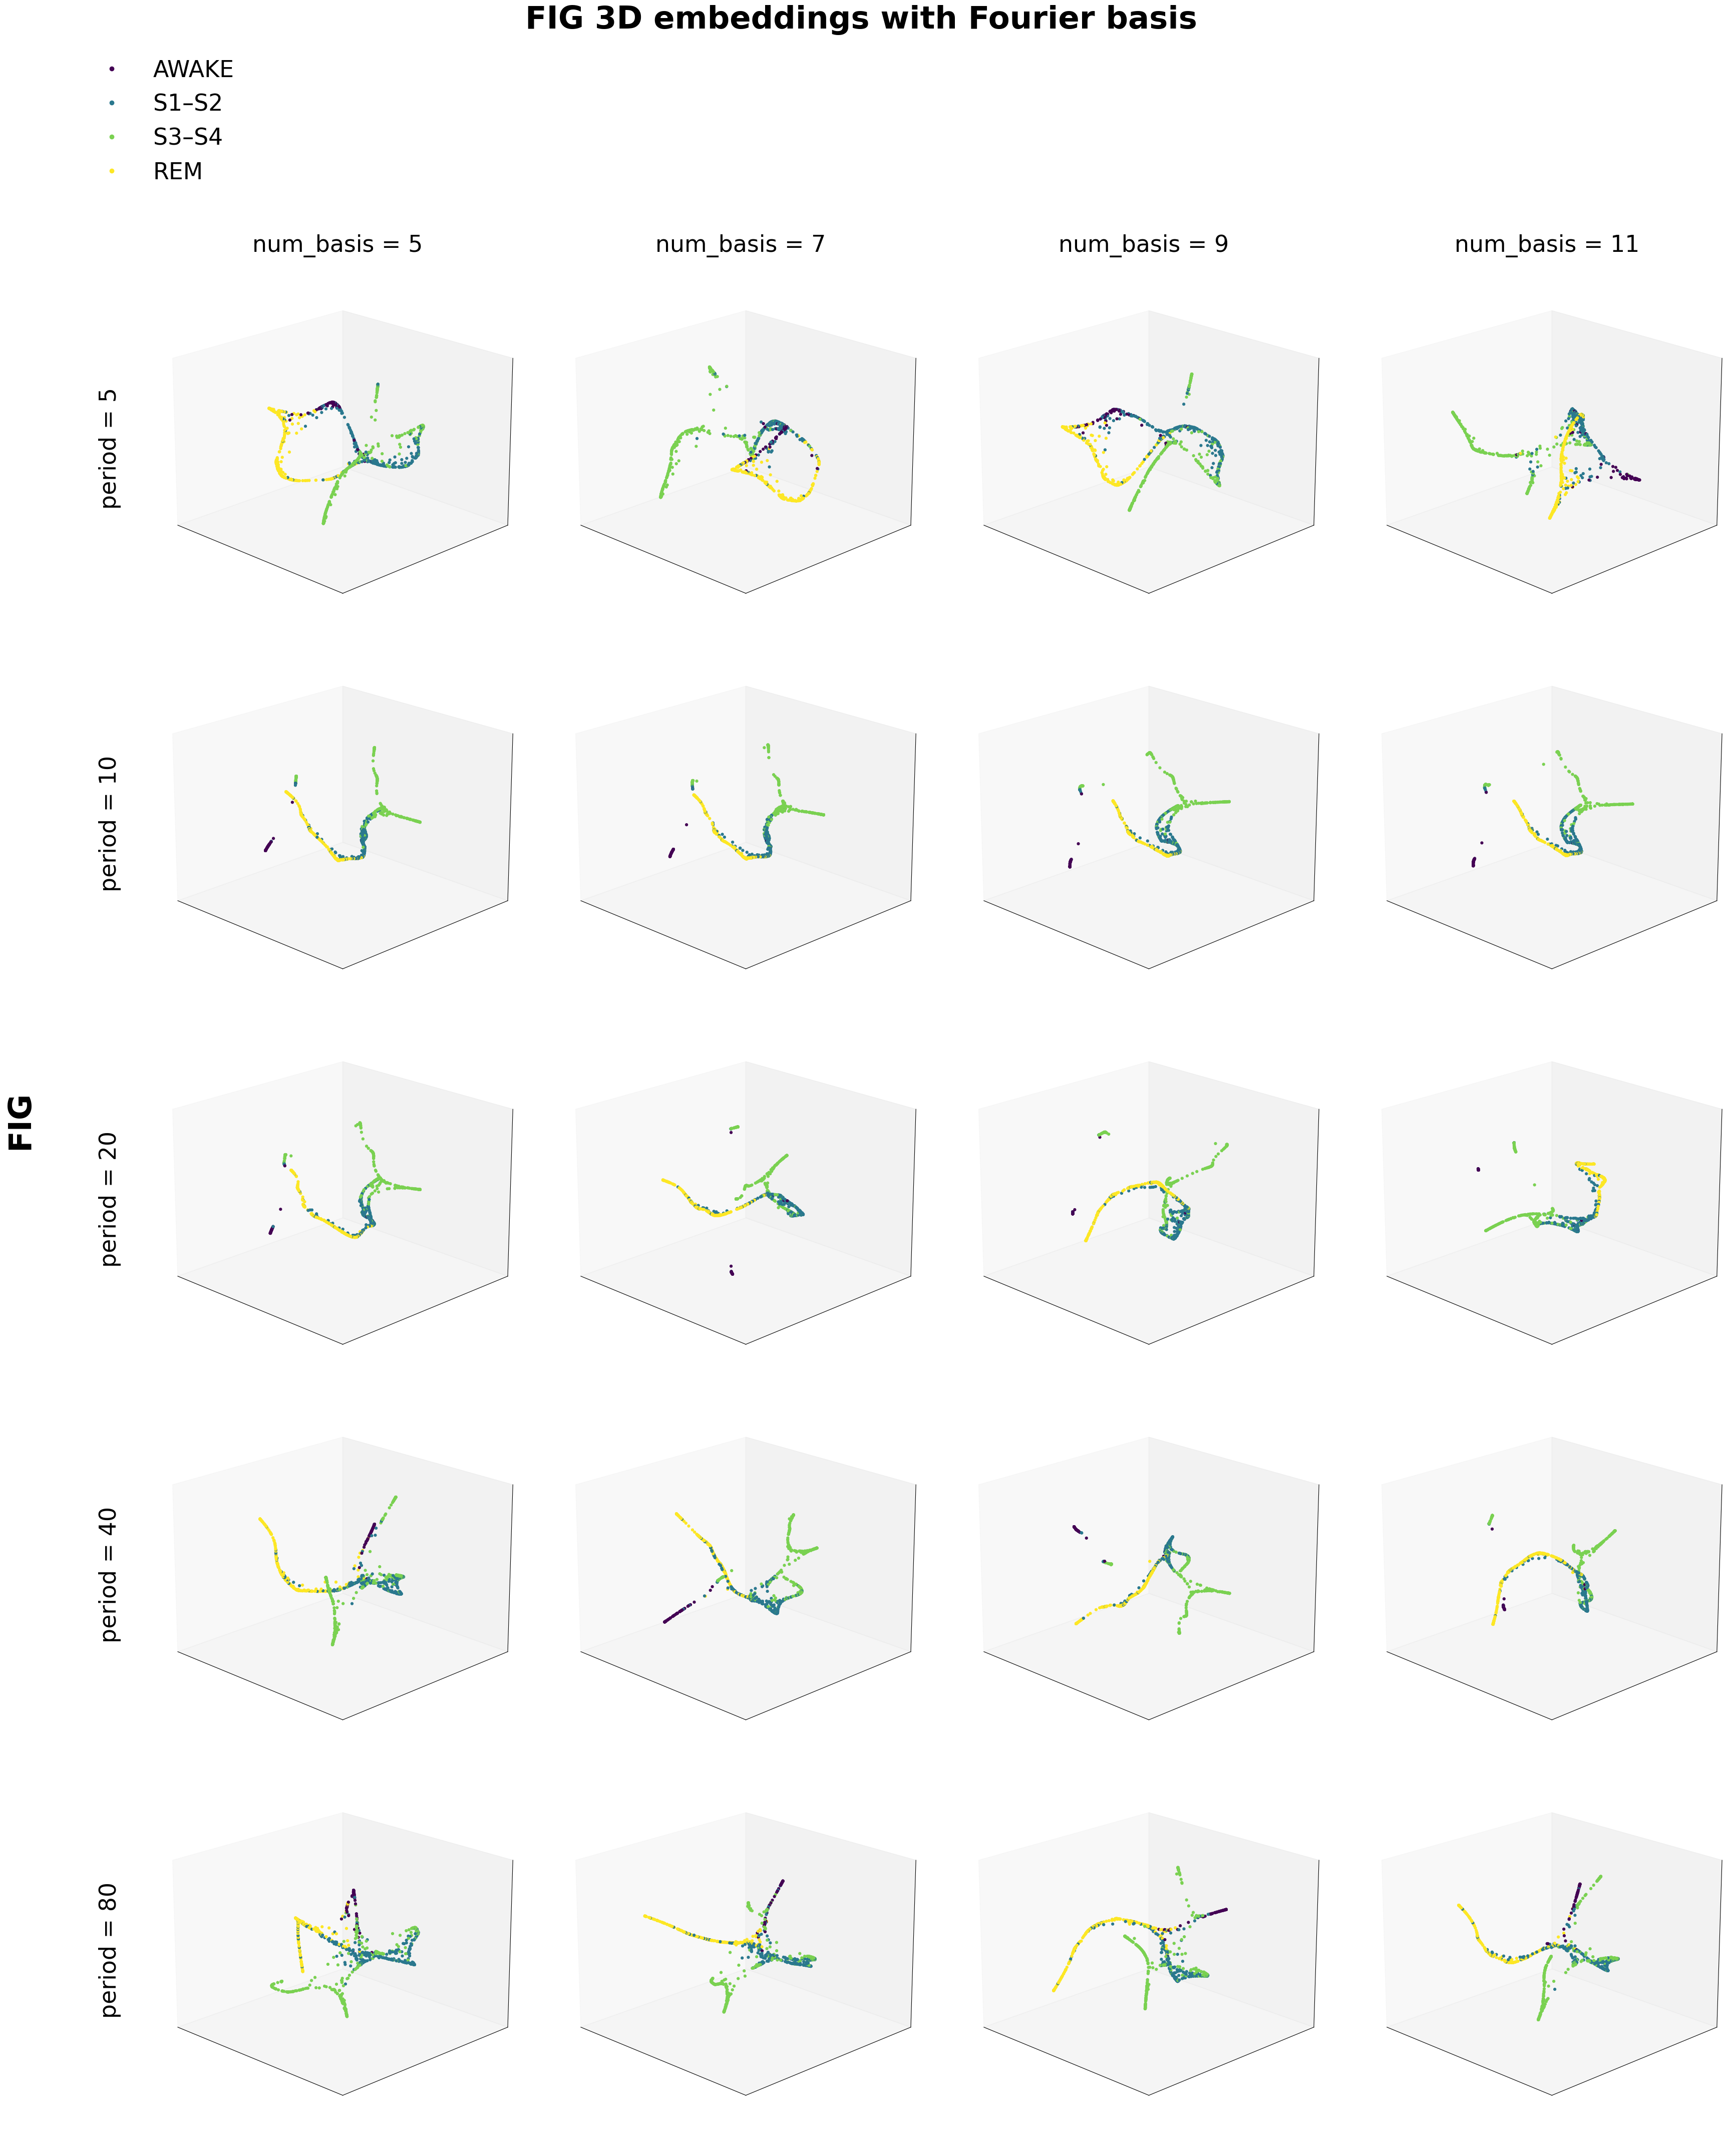

In [9]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ==================================================
# Step 0: merge labels (ONCE)
# ==================================================
labels_merged = labels.copy()
labels_merged[np.isin(labels_merged, [1, 2])] = 2   # S1–S2
labels_merged[np.isin(labels_merged, [3, 4])] = 4   # S3–S4

# ==================================================
# Directory
# ==================================================
base_dir = "/Users/chenhaozhe/Desktop/FIG/basis_fourier_MD"

# ==================================================
# Grid definition (4 x 5)
# ==================================================
num_basis_list = [5, 7, 9, 11]          # columns
period_list = [5, 10, 20, 40, 80]       # rows

# ==================================================
# Legend dictionary
# ==================================================
legend_dict = {
    0: "AWAKE",
    2: "S1–S2",
    4: "S3–S4",
    5: "REM",
}

# ==================================================
# STEP 1: compute global 3D axis limits
# ==================================================
all_points = []

for period in period_list:
    for num_basis in num_basis_list:
        fname = f"fig_3d_MD_fourier_nb{num_basis}_p{period}.npy"
        Z = np.load(os.path.join(base_dir, fname))
        all_points.append(Z)

all_points = np.vstack(all_points)

x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
z_min, z_max = all_points[:, 2].min(), all_points[:, 2].max()

# Padding
pad_x = 0.05 * (x_max - x_min)
pad_y = 0.05 * (y_max - y_min)
pad_z = 0.05 * (z_max - z_min)

xlim = (x_min - pad_x, x_max + pad_x)
ylim = (y_min - pad_y, y_max + pad_y)
zlim = (z_min - pad_z, z_max + pad_z)

# ==================================================
# Dummy scatter (legend handles only)
# ==================================================
dummy_fig = all_points[:len(labels_merged)]

scatterplot = plt.scatter(
    dummy_fig[:, 0],
    dummy_fig[:, 1],
    c=labels_merged,
    s=12,
)
plt.close()

# ==================================================
# Create figure (3D subplots)
# ==================================================
fig = plt.figure(figsize=(36, 45))
axes = np.empty((len(period_list), len(num_basis_list)), dtype=object)

for i in range(len(period_list)):
    for j in range(len(num_basis_list)):
        axes[i, j] = fig.add_subplot(
            len(period_list),
            len(num_basis_list),
            i * len(num_basis_list) + j + 1,
            projection="3d",
        )

# ==================================================
# Plot loop
# ==================================================
for i, period in enumerate(period_list):
    for j, num_basis in enumerate(num_basis_list):
        ax = axes[i, j]

        fname = f"fig_3d_MD_fourier_nb{num_basis}_p{period}.npy"
        Z = np.load(os.path.join(base_dir, fname))

        ax.scatter(
            Z[:, 0],
            Z[:, 1],
            Z[:, 2],
            c=labels_merged,
            s=12,
            depthshade=False,
        )

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        # Consistent viewing angle
        ax.view_init(elev=20, azim=135)

        # Column titles
        if i == 0:
            ax.set_title(
                f"num_basis = {num_basis}",
                fontsize=33,
                pad=18,
            )

        # Row labels
        if j == 0:
            ax.text2D(
                -0.15,
                0.5,
                f"period = {period}",
                transform=ax.transAxes,
                fontsize=33,
                rotation=90,
                va="center",
            )

# ==================================================
# Global FIG label
# ==================================================
fig.text(
    0.025,
    0.5,
    "FIG",
    va="center",
    rotation="vertical",
    fontsize=45,
    fontweight="bold",
)

# ==================================================
# Global legend
# ==================================================
legend_labels = [legend_dict[label] for label in np.unique(labels_merged)]

fig.legend(
    handles=scatterplot.legend_elements()[0],
    labels=legend_labels,
    loc="upper left",
    bbox_to_anchor=(0.06, 0.98),
    fontsize=33,
    frameon=False,
)

# ==================================================
# Global title
# ==================================================
fig.suptitle(
    "FIG 3D embeddings with Fourier basis",
    fontsize=45,
    y=0.995,
    fontweight="bold",
)

# ==================================================
# Layout tuning
# ==================================================
plt.subplots_adjust(
    left=0.1,
    right=0.99,
    top=0.88,
    bottom=0.05,
    wspace=0.02,
    hspace=0.02,
)

plt.show()
